In [1]:
!pip install transformers

     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 890kB 15.6MB/s 
     |████████████████████████████████| 2.9MB 19.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=72870ca31f0e42562652d0546b18d77da2e7517db019efa76d31c22e9c49a62a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

#**How to replicate the code**

This is one of the checkpoints, **Checkpoint: O**. So to run the script, when you're running it for trained on Tales and evaluated on Tales, then proceed normally until you reach **Checkpoint S** and then stop. But when you want to train on Tales and evaluate Isear, skip the part of the code till you find **Checkpoint: P** and you need to run that until **Checkpoint: Q** and come back to **Checkpoint: R** until you can reach **Checkpoint: X**. And then finally find and execute the section with **Checkpoints S to T**.

**Load the Unified Dataset and find all the unique datasets in it.**

In [3]:
# imports
import numpy as np
import pandas as pd

# set pandas to display the maximum range if necessary
pd.set_option("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None)
pd.options.mode.chained_assignment = None  # default='warn'

df = pd.read_json (r'/content/drive/MyDrive/Colab Notebooks/emotion_data/unified-dataset.json', lines=True)
set(df['source'])

{'affectivetext',
 'crowdflower',
 'dailydialogues',
 'electoraltweets',
 'emoint',
 'emotion-cause',
 'emotiondata-aman',
 'fb-valence-arousal-anon',
 'grounded_emotions',
 'isear',
 'ssec',
 'tales-emotion',
 'tec'}

**Extract Tales for analysis**

In [4]:
print(len(df.loc[df['source'] == 'tales-emotion']))
df_tales = df.loc[df['source'] == 'tales-emotion']
df_tales[:1]

14771


,id,VAD,source,text,emotions,split,emotion_model,annotation_procedure,domain,labeled,optional
200696,200696,"{'valence': None, 'arousal': None, 'dominance': None}",tales-emotion,What a funny sight it is to see a brood of ducklings with a hen!,"{'joy': 0, 'anger': 0, 'sadness': 0, 'disgust': 0, 'fear': 0, 'trust': None, 'surprise': 0, 'love': None, 'noemo': 1, 'confusion': None, 'anticipation': None, 'shame': None, 'guilt': None}",NaN,Ekman,NaN,fairytale_sentences,single,{'_tales_source': 'the_tale_of_jemima_puddle-duck.emmood'}


**More preprocessing to clean up the dataset**

Discarding a the columns which are not really required and also flagging observations where there are no emotion labels. Also dropped *surprise* as it wasn't in Isear for easier comparison.

In [5]:
emotions = df_tales['emotions']
target_emotions = []
for index in emotions:
    foo = {k: index[k] for k in index.keys() & {'joy', 'anger', 'sadness', 'disgust','fear'}}
    # foo = {k: index[k] for k in index.keys()}
    if all(value == 0 for value in foo.values()):
        foo = 'None'
    else:
        foo = list(foo.keys())[list(foo.values()).index(1)]
    target_emotions.append(foo)
df_tales['target_emotions']= pd.Series(target_emotions).values
df_tales = df_tales.drop(['id', 'VAD', 'source', 'emotions', 'split', 'emotion_model', 'annotation_procedure', 'domain', 'labeled', 'optional'], axis=1)
df_tales[:2]

,text,target_emotions
200696,What a funny sight it is to see a brood of ducklings with a hen!,None
200697,"Listen to the story of Jemima Puddle-duck, who was annoyed because the farmer's wife would not let her hatch her own eggs.",anger


**Drop the None labels to make the classes comparable.**
This is done to make the classes similar for comparison later on (Tales-Emotion vs Isear).

In [6]:
indexNames = df_tales[df_tales['target_emotions'] == 'None'].index
df_tales.drop(indexNames , inplace=True)
df_tales[:2]

,text,target_emotions
200697,"Listen to the story of Jemima Puddle-duck, who was annoyed because the farmer's wife would not let her hatch her own eggs.",anger
200698,"Her sister-in-law, Mrs. Rebeccah Puddle-duck, was perfectly willing to leave the hatching to someone else-- ""I have not the patience to sit on a nest for twenty-eight days; and no more have you, Jemima.",anger


**Comparison of Class Sizes**
Here, we see a bit of class imbalance with Joy and the rest. I wanted to see how much of a difference that made, and then test it again for when class sizes were balanced, but didn't have time to test out that theory.

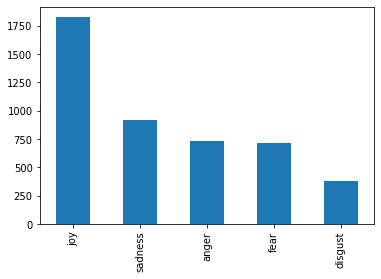

In [7]:
from matplotlib import pyplot
df_tales['target_emotions'].value_counts().plot(kind='bar')

**Labeling the unique emotions which are kept**
Note: While creating the model for Isear, I didn't make the label names consistent with this Isear labeling scheme. So I had to adjust for it later. You'll see.

In [8]:
possible_labels = df_tales.target_emotions.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'anger': 0, 'disgust': 4, 'fear': 2, 'joy': 1, 'sadness': 3}

In [9]:
df_tales['label'] = df_tales.target_emotions.replace(label_dict)
df_tales.head()

,text,target_emotions,label
200697,"Listen to the story of Jemima Puddle-duck, who was annoyed because the farmer's wife would not let her hatch her own eggs.",anger,0
200698,"Her sister-in-law, Mrs. Rebeccah Puddle-duck, was perfectly willing to leave the hatching to someone else-- ""I have not the patience to sit on a nest for twenty-eight days; and no more have you, Jemima.",anger,0
200699,"You would let them go cold; you know you would!""",anger,0
200700,"""I wish to hatch my own eggs; I will hatch them all by myself,"" quacked Jemima Puddle-duck.",anger,0
200712,She rather fancied a tree stump amongst some tall foxgloves.,joy,1


**Save the processed data to file for later reuse**

In [ ]:
import pickle
df_tales.to_pickle("/content/drive/MyDrive/Colab Notebooks/emotion_data/tales_refactored.pkl")

**Checkpoint: O**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_tales.index.values, 
                                                  df_tales.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df_tales.label.values)
df_tales['data_type'] = ['not_set']*df_tales.shape[0]

df_tales.loc[X_train, 'data_type'] = 'train'
df_tales.loc[X_val, 'data_type'] = 'val'
df_tales.groupby(['target_emotions', 'label', 'data_type']).count()

text
target_emotions label data_type      
anger           0     train       622
                      val         110
disgust         4     train       321
                      val          57
fear            2     train       605
                      val         107
joy             1     train      1553
                      val         274
sadness         3     train       783
                      val         138

**Checkpoint: R**

**Load the Tokenizer and encode the data into their corresponding labels**

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [15]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_tales[df_tales.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df_tales[df_tales.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_tales[df_tales.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_tales[df_tales.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [16]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

**Train-Validation Split sizes**

In [17]:
len(dataset_train), len(dataset_val)

(3884, 686)

**Load the Base Bert model**

In [18]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

**Code for the transformer implementation with the scoring functions, optimizer, and evaluation.**

In [19]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [20]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [21]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [22]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [23]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [25]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

**Note: Ran this model on Google Colab. The server kept timing out and didn't have time to run this on the IMS server.**

So only the first two epoch models have been saved.

**Checkpoint: X**

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
          
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/emotion_data/finetuned_BERT_tales_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')



Epoch 1
Training loss: 1.0848864036694916
Validation loss: 0.9528113546899182
F1 Score (Weighted): 0.6422101470669599



Epoch 2
Training loss: 0.6870582083358814
Validation loss: 1.0150305428054167
F1 Score (Weighted): 0.6979603524599128


**Load the Bert model and save it to the local running device.**
Loaded it again here because I noticed that sometimes because of timeout, the model would get deleted from the local cache on Colab.

In [26]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

**Load the fine-tuned model which ran for the two epochs and predict class accuracy.**

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/emotion_data/finetuned_BERT_tales_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
accuracy_per_class(predictions, true_vals)

Class: anger
Accuracy: 70/110

Class: joy
Accuracy: 192/274

Class: fear
Accuracy: 57/107

Class: sadness
Accuracy: 114/138

Class: disgust
Accuracy: 10/57



In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/emotion_data/finetuned_BERT_tales_epoch_2.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
accuracy_per_class(predictions, true_vals)

Class: anger
Accuracy: 63/110

Class: joy
Accuracy: 239/274

Class: fear
Accuracy: 60/107

Class: sadness
Accuracy: 106/138

Class: disgust
Accuracy: 17/57



**Comparison on how the class accuracy prediction improves from the first to the next.**
Learns some and gets bad on some others. So do note that this doesn't necessarily indicate that the model is learning. We can't know that until we run the model for around 10-15 epochs and see its peak performance.

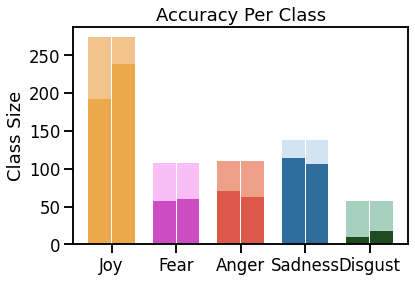

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

emotion_labels = ['Joy', 'Fear', 'Anger', 'Sadness', 'Disgust']

total_1 = [274, 107, 110, 138, 57]

score_1 = [192, 57, 70, 114, 10]
error_1 = []
for score_i, total_i in zip(score_1, total_1):
    error_1.append(total_i-score_i)

total_2 = [274, 107, 110, 138, 57]

score_2 = [239, 60, 63, 106, 17]
error_2 = []
for score_i, total_i in zip(score_2, total_2):
    error_2.append(total_i-score_i)

score_color = ['#EBA94B', '#CC4CC3', '#DC5849', '#2E6E9C', '#204B20']
error_color = ['#F2C38B', '#F9BEF6', '#ECA088', '#D2E4F2', '#A6D1C0']

x = np.arange(len(emotion_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/1.9, score_1, width, color=score_color)
rects3 = ax.bar(x - width/1.9, error_1, width, bottom=score_1, color=error_color)
rects2 = ax.bar(x + width/1.9, score_2, width, color=score_color)
rects4 = ax.bar(x + width/1.9, error_2, width, bottom=score_2, color=error_color)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Class Size')
ax.set_title('Accuracy Per Class')

ax.set_xticks(x)
ax.set_xticklabels(emotion_labels)

plt.show()

**Checkpoint: P**

In [10]:
isear_df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/emotion_data/isear_refactored.pkl")

**See how the labels have been adjusted**

In [11]:
# source -> {'anger': 2, 'disgust': 4, 'fear': 1, 'joy': 0, 'sadness': 3}
# target -> {'anger': 0, 'disgust': 4, 'fear': 2, 'joy': 1, 'sadness': 3}

for i, row in isear_df.iterrows():
  if isear_df.loc[i,'label']  == 0:
    isear_df.loc[i,'label'] = 1
  elif isear_df.loc[i,'label'] == 2:
    isear_df.loc[i,'label'] = 0
  elif isear_df.loc[i,'label'] == 1:
    isear_df.loc[i,'label'] = 2

**Note that the total dataset size has been kept constant. So we had 3884-686 for the tales-tales train-val split. Now we have the same 3884-686, but for the tales-isear test-train sample size.**

In [13]:
from sklearn.model_selection import train_test_split

rand_tales = df_tales.sample(n=3884, random_state=42)
rand_isear = isear_df.sample(n=686, random_state=42)

df_tales = pd.concat([rand_tales, rand_isear])

X_train, X_val, y_train, y_val = train_test_split(df_tales.index.values, 
                                                  df_tales.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df_tales.label.values)
df_tales['data_type'] = ['not_set']*df_tales.shape[0]

df_tales.loc[X_train, 'data_type'] = 'train'
df_tales.loc[X_val, 'data_type'] = 'val'
df_tales.groupby(['target_emotions', 'label', 'data_type']).count()

text
target_emotions label data_type      
anger           0     train       654
                      val         116
disgust         4     train       385
                      val          68
fear            2     train       632
                      val         111
joy             1     train      1431
                      val         253
sadness         3     train       782
                      val         138

**Checkpoint: Q**
Go back here without running the next block.

**Checkpoint: S**

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

In [27]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/emotion_data/finetuned_BERT_tales_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [28]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [29]:
accuracy_per_class(predictions, true_vals)

Class: anger
Accuracy: 82/116

Class: joy
Accuracy: 220/253

Class: fear
Accuracy: 69/111

Class: sadness
Accuracy: 118/138

Class: disgust
Accuracy: 11/68



In [30]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/emotion_data/finetuned_BERT_tales_epoch_2.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [31]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [32]:
accuracy_per_class(predictions, true_vals)

Class: anger
Accuracy: 83/116

Class: joy
Accuracy: 241/253

Class: fear
Accuracy: 83/111

Class: sadness
Accuracy: 121/138

Class: disgust
Accuracy: 27/68



**The tales model starts predicting significantly well after the second epoch**
To be taken with a grain of salt as usual as performance may drop later on because of overfitting or something else.

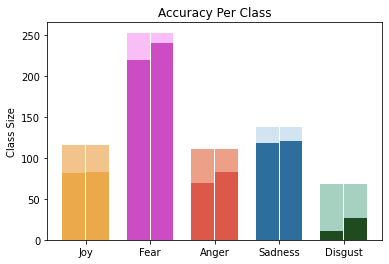

In [33]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

emotion_labels = ['Joy', 'Fear', 'Anger', 'Sadness', 'Disgust']

total_1 = [116, 253, 111, 138, 68]

score_1 = [82, 220, 69, 118, 11]
error_1 = []
for score_i, total_i in zip(score_1, total_1):
    error_1.append(total_i-score_i)

total_2 = [116, 253, 111, 138, 68]

score_2 = [83, 241, 83, 121, 27]
error_2 = []
for score_i, total_i in zip(score_2, total_2):
    error_2.append(total_i-score_i)

score_color = ['#EBA94B', '#CC4CC3', '#DC5849', '#2E6E9C', '#204B20']
error_color = ['#F2C38B', '#F9BEF6', '#ECA088', '#D2E4F2', '#A6D1C0']

x = np.arange(len(emotion_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/1.9, score_1, width, color=score_color)
rects3 = ax.bar(x - width/1.9, error_1, width, bottom=score_1, color=error_color)
rects2 = ax.bar(x + width/1.9, score_2, width, color=score_color)
rects4 = ax.bar(x + width/1.9, error_2, width, bottom=score_2, color=error_color)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Class Size')
ax.set_title('Accuracy Per Class')

ax.set_xticks(x)
ax.set_xticklabels(emotion_labels)

plt.show()

**Checkpoint: T**